In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout


def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

# Loading dataset
exchange_data = pd.read_csv('GBPUSD.csv')
exchange_data.head()

,Date,open,high,low,close,tick_volume,spread,real_volume
0,1994-01-03,1.4780,1.4850,1.4744,1.4752,1841,50,0
1,1994-01-04,1.4754,1.4877,1.4740,1.4858,1701,50,0
2,1994-01-05,1.4858,1.4906,1.4810,1.4860,1901,50,0
3,1994-01-06,1.4864,1.4902,1.4790,1.4812,1721,50,0
4,1994-01-07,1.4810,1.4960,1.4800,1.4930,2001,50,0


In [3]:
# Changing format to datetime and indexing data
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

ind_exchange_data.head()

,open,high,low,close,tick_volume,spread,real_volume
Date,,,,,,,
1994-01-03,1.4780,1.4850,1.4744,1.4752,1841,50,0
1994-01-04,1.4754,1.4877,1.4740,1.4858,1701,50,0
1994-01-05,1.4858,1.4906,1.4810,1.4860,1901,50,0
1994-01-06,1.4864,1.4902,1.4790,1.4812,1721,50,0
1994-01-07,1.4810,1.4960,1.4800,1.4930,2001,50,0


In [4]:
# Sorting data in ascending order
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,close,high,low,open,real_volume,spread,tick_volume
Date,,,,,,,
2023-01-03,1.19656,1.20841,1.18996,1.20411,195191500000,15,780766
2023-01-02,1.20411,1.21014,1.20325,1.20650,73724750000,15,294899
2022-12-30,1.20971,1.21067,1.20092,1.20533,194686000000,14,778744
2022-12-29,1.20533,1.20780,1.20091,1.20144,198733000000,15,794932
2022-12-28,1.20147,1.21252,1.20013,1.20171,192053000000,15,768212


<AxesSubplot:xlabel='Date'>

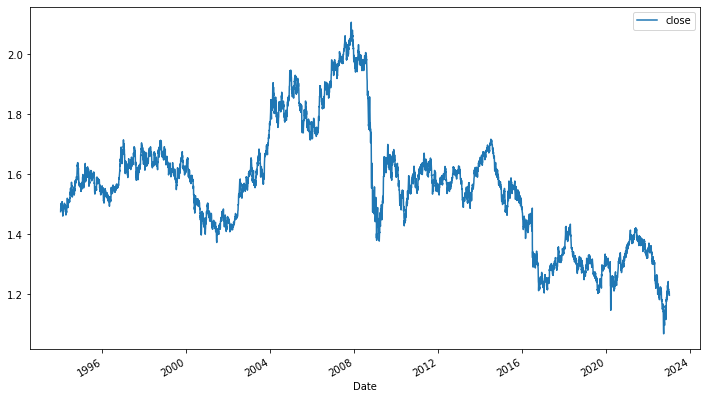

In [5]:
df = data_frame[["close"]]

df.plot(kind='line',figsize=(12,7))

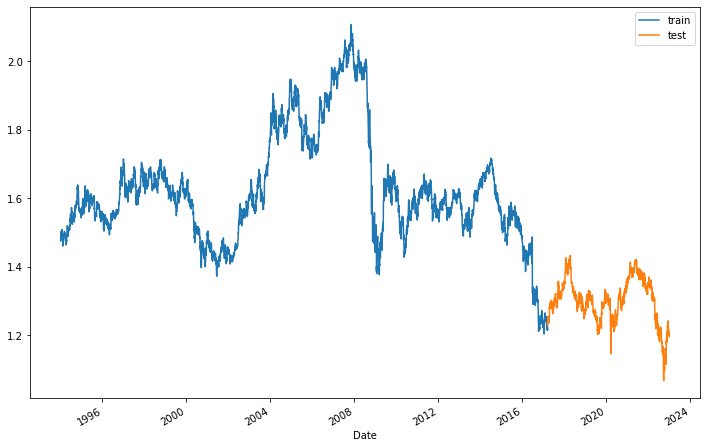

In [6]:
split_date = pd.Timestamp('15-03-2017')

train = df.loc[split_date:]
test = df.loc[:split_date]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [7]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

X_train

array([[-2.43231708],
       [-2.51386669],
       [-2.4746909 ],
       ...,
       [-0.87875388],
       [-0.84923366],
       [-0.85046367]])

In [8]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

2024-04-07 20:41:03.333536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 20:41:03.348859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 20:41:03.348892: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 20:41:03.351550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 20:41:03.351580: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                24        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 20:41:03.509070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9572 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200


2024-04-07 20:41:12.781648: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-07 20:41:12.982893: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3899bf9b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 20:41:12.982914: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-04-07 20:41:12.985740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-07 20:41:12.995785: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1712515273.041670   83383 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6053/6053 [==============================] - 10s 1ms/step - loss: 0.2052 - rmse: 0.4529
Epoch 2/200
6053/6053 [==============================] - 11s 2ms/step - loss: 0.0062 - rmse: 0.0786
Epoch 3/200
6053/6053 [==============================] - 12s 2ms/step - loss: 0.0050 - rmse: 0.0706
Epoch 4/200
6053/6053 [==============================] - 10s 2ms/step - loss: 0.0050 - rmse: 0.0708
Epoch 5/200
6053/6053 [==============================] - 10s 2ms/step - loss: 0.0049 - rmse: 0.0701
Epoch 6/200
6053/6053 [==============================] - 10s 2ms/step - loss: 0.0049 - rmse: 0.0697
Epoch 7/200
6053/6053 [==============================] - 10s 2ms/step - loss: 0.0048 - rmse: 0.0696
Epoch 8/200
6053/6053 [==============================] - 11s 2ms/step - loss: 0.0048 - rmse: 0.0690
Epoch 9/200
6053/6053 [==============================] - 10s 2ms/step - loss: 0.0048 - rmse: 0.0691
Epoch 10/200
6053/6053 [==============================] - 9s 2ms/step - loss: 0.0047 - rmse: 0.0683
Epoch 11/200

In [11]:
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("Train - R2:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("Train - MAE:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))
print("Train - RMSE:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("Train - upravene R2:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))

print("Test - R2:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("Test - MAE:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("Test - RMSE:\t{:0.3f}".format(rmse_test))
print("Test - upravene R2:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

190/190 [==============================] - 0s 756us/step
Train - R2:	0.989
Train - MAE:	0.078
Train - RMSE:	0.104
Train - upravene R2:	0.989

Test - R2:	0.926
Test - MAE:	0.095
Test - RMSE:	0.108
Test - upravene R2:	0.926


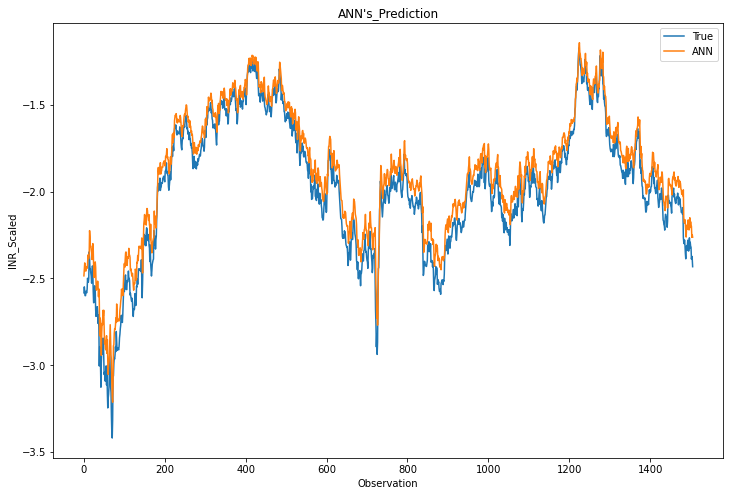

In [12]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [17]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [18]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', 
                    return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
6053/6053 [==============================] - 18s 3ms/step - loss: 0.0043 - rmse: 0.0652
Epoch 2/100
6053/6053 [==============================] - 17s 3ms/step - loss: 0.0038 - rmse: 0.0617
Epoch 3/100
6053/6053 [==============================] - 19s 3ms/step - loss: 0.0038 - rmse: 0.0617
Epoch 4/100
6053/6053 [==============================] - 19s 3ms/step - loss: 0.0038 - rmse: 0.0616
Epoch 5/100
6053/6053 [==============================] - 17s 3ms/step - loss: 0.0038 - rmse: 0.0615
Epoch 6/100
6053/6053 [==============================] - 20s 3ms/step - loss: 0.0038 - rmse: 0.0613
Epoch 7/100
6053/6053 [==============================] - 19s 3ms/step - loss: 0.0037 - rmse: 0.0610
Epoch 8/100
6053/6053 [==============================] - 18s 3ms/step - loss: 0.0037 - rmse: 0.0608
Epoch 9/100
6053/6053 [==============================] - 18s 3ms/step - loss: 0.0037 - rmse: 0.0606
Epoch 10/100
6053/6053 [==============================] - 16s 3ms/step - loss: 0.0037 - rmse: 0.0604

In [22]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print("Train - R2:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("Train - MAE\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))
print("Train - RMSE:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("Train - upravene R2:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))


print("Test - R2:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("Test - MAE:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("Test - RMSE:\t{:0.3f}".format(rmse_test))
print("Test - upravene R2:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

190/190 [==============================] - 0s 2ms/step
Train - R2:	0.977
Train - MAE	0.102
Train - RMSE:	0.151
Train - upravene R2:	0.977

Test - R2:	0.738
Test - MAE:	0.184
Test - RMSE:	0.202
Test - upravene R2:	0.738


NameError: name 'plt' is not defined